In [1]:
import math
import torch
import torch.nn as nn
import numpy as np
from tensorboardX import SummaryWriter
import time

#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2"


In [2]:


USE_MULTI_GPU = False
if USE_MULTI_GPU:
    #多gpu
    device = torch.device("cuda:0,1,2" if torch.cuda.is_available() else "cpu")
    device_ids = [0, 1, 2]
else:
    #单gpu
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    

In [3]:
#定义一个类，继承自nn.module

#输入的数据维度, [batch_size, length, feature_length]

#matrix: [feature_length, hidden_length]

In [4]:
class NaiveCustomLSTM(nn.Module):
    
    #input_sz: 输入的x的维度, hidden_sz:隐藏单元h的维度
    def __init__(self, input_sz:int, hidden_sz:int):
        
        super().__init__()
        
        self.input_size = input_sz
        self.hidden_size = hidden_sz
        
        #i, 输入门，新增的信息  基于ht-1, xt
        self.U_i = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.V_i = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_i = nn.Parameter(torch.Tensor(hidden_sz))
        
        #f, 遗忘门, 忘记的信息　基于ht-1, xt
        self.U_f = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.V_f = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_f = nn.Parameter(torch.Tensor(hidden_sz))
        
        #c, 新增的信息  
        self.U_c = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.V_c = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_c = nn.Parameter(torch.Tensor(hidden_sz))
        
        #o, 根据cell更新hidden cell
        self.U_o = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.V_o = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_o = nn.Parameter(torch.Tensor(hidden_sz))
        
        self.init_weights()
        

    #均匀分布，初始化各个weights
    def init_weights(self):
        stdv = 1.0/math.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)


    def forward(self, x, init_states=None):
        '''
        assume x.shape represents (batch_size, sequence_size, input_size)
        '''

        
        bs, seq_sz, _ = x.size()

        hidden_seq = []

        
        if init_states is None:
            h_t, c_t = (
                torch.zeros(bs, self.hidden_size).to(x.device),
                torch.zeros(bs, self.hidden_size).to(x.device),
            )                
        else:
            h_t, c_t = init_states

        
        for t in range(seq_sz):
            x_t = x[:, t, :]

            
            i_t = torch.sigmoid(x_t@self.U_i + h_t@self.V_i + self.b_i)

            
            f_t = torch.sigmoid(x_t@self.U_f + h_t@self.V_f + self.b_f)

            
            o_t = torch.sigmoid(x_t@self.U_o + h_t@self.V_o + self.b_o)

           
            g_t = torch.tanh(x_t@self.U_c + h_t@self.V_c + self.b_c)

            c_t = f_t * c_t + i_t * g_t
            h_t = o_t * torch.tanh(c_t)

            
            hidden_seq.append(h_t.unsqueeze(0))

        
        hidden_seq = torch.cat(hidden_seq, dim=0)

        
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()

        
        return hidden_seq, (h_t, c_t)
            


In [5]:
class CustomLSTM(nn.Module):
    
    def __init__(self, input_sz:int, hidden_sz:int, bidirection:bool, layer_num:int):
        
        super().__init__()
        
        self.input_size = input_sz
        self.hidden_size = hidden_sz
        self.bidirection = bidirection
        self.layer_num = layer_num
        
        
        self.U = nn.Parameter(torch.Tensor(input_sz, hidden_sz*4))
        self.V = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz*4))
        self.b = nn.Parameter(torch.Tensor(hidden_sz*4))


        if self.bidirection:
            self.U2 = nn.Parameter(torch.Tensor(input_sz, hidden_sz*4))
            self.V2 = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz*4))
            self.b2 = nn.Parameter(torch.Tensor(hidden_sz*4))
            
            
       
        if self.layer_num > 1:
            self.layers_U = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz*4*(self.layer_num - 1)))
            self.layers_V = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz*4*(self.layer_num - 1)))
            self.layers_b = nn.Parameter(torch.Tensor(hidden_sz*4*(self.layer_num - 1)))

            if self.bidirection:
                self.layers_U2 = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz*4*(self.layer_num - 1)))
                self.layers_V2 = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz*4*(self.layer_num - 1)))
                self.layers_b2 = nn.Parameter(torch.Tensor(hidden_sz*4*(self.layer_num - 1)))

        
        self.init_weights()
        

    def init_weights(self):
        stdv = 1.0/math.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)

            
    def init_ct(self, bs, device):
        h_t, c_t = (
            torch.zeros(bs, self.hidden_size).to(device),
            torch.zeros(bs, self.hidden_size).to(device),
        )

        return h_t, c_t


            
    def forward(self, x, init_states=None):
        '''
        assume x.shape represents (batch_size, sequence_size, input_size)
        '''

        bs, seq_sz, _ = x.size()
        hidden_sz = self.hidden_size 
        hidden_seq = []

        if self.bidirection:
            hidden_seq2 = []
        
        if self.layer_num > 1:
            hidden_seq_layers = []  
            if self.bidirection:
                hidden_seq2_layers = [] 
        
        if self.layer_num > 0:
            last_hidden_h_layers = []  
            last_hidden_c_layers = []  
            if self.bidirection:
                last_hidden2_h_layers = [] 
                last_hidden2_c_layers = [] 
                
        

        if init_states is None:

            if self.bidirection:
                h_t, c_t = self.init_ct(bs, x.device)
                h_t2, c_t2 = self.init_ct(bs, x.device)
            else:
                h_t, c_t = self.init_ct(bs, x.device)
                
        else:
            h_t, c_t = init_states
            if self.bidirection:
                h_t2, c_t2 = init_states
            
        

        U_i, V_i, b_i = self.U[:,0:hidden_sz], self.V[:,0:hidden_sz], self.b[0:hidden_sz]
        U_f, V_f, b_f = self.U[:,hidden_sz:hidden_sz*2], self.V[:,hidden_sz:hidden_sz*2], self.b[hidden_sz:hidden_sz*2]
        U_c, V_c, b_c = self.U[:,hidden_sz*2:hidden_sz*3], self.V[:,hidden_sz*2:hidden_sz*3], self.b[hidden_sz*2:hidden_sz*3]
        U_o, V_o, b_o = self.U[:,hidden_sz*3:hidden_sz*4], self.V[:,hidden_sz*3:hidden_sz*4], self.b[hidden_sz*3:hidden_sz*4]
        
        if self.bidirection:
            U_i2, V_i2, b_i2 = self.U2[:,0:hidden_sz], self.V2[:,0:hidden_sz], self.b2[0:hidden_sz]
            U_f2, V_f2, b_f2 = self.U2[:,hidden_sz:hidden_sz*2], self.V2[:,hidden_sz:hidden_sz*2], self.b2[hidden_sz:hidden_sz*2]
            U_c2, V_c2, b_c2 = self.U2[:,hidden_sz*2:hidden_sz*3], self.V2[:,hidden_sz*2:hidden_sz*3], self.b2[hidden_sz*2:hidden_sz*3]
            U_o2, V_o2, b_o2 = self.U2[:,hidden_sz*3:hidden_sz*4], self.V2[:,hidden_sz*3:hidden_sz*4], self.b2[hidden_sz*3:hidden_sz*4]
        

        for t in range(seq_sz):
            x_t = x[:, t, :]            
            gates = x_t@self.U + h_t@self.V + self.b   
            i_t, f_t, g_t, o_t = (
            torch.sigmoid(gates[:,0:hidden_sz]), 
            torch.sigmoid(gates[:,hidden_sz:hidden_sz*2]),
            torch.tanh(gates[:,hidden_sz*2:hidden_sz*3]), 
            torch.sigmoid(gates[:,hidden_sz*3:hidden_sz*4]),
            )


            c_t = f_t * c_t + i_t * g_t
            h_t = o_t * torch.tanh(c_t)


            hidden_seq.append(h_t.unsqueeze(0))
        last_hidden_h_layers.append(h_t) 
        last_hidden_c_layers.append(c_t) 
            
            
        if self.bidirection:
            for t in range(seq_sz, 0, -1):
                x_t = x[:, t-1, :]            
                gates2 = x_t@self.U2 + h_t2@self.V2 + self.b2   
                i_t2, f_t2, g_t2, o_t2 = (
                torch.sigmoid(gates2[:,0:hidden_sz]), 
                torch.sigmoid(gates2[:,hidden_sz:hidden_sz*2]),
                torch.tanh(gates2[:,hidden_sz*2:hidden_sz*3]), 
                torch.sigmoid(gates2[:,hidden_sz*3:hidden_sz*4]),
                )


                c_t2 = f_t2 * c_t2 + i_t2 * g_t2
                h_t2 = o_t2 * torch.tanh(c_t2)

               
                hidden_seq2.append(h_t2.unsqueeze(0))
            last_hidden2_h_layers.append(h_t2)
            last_hidden2_c_layers.append(c_t2)


        hidden_seq = torch.cat(hidden_seq, dim=0)
        if self.bidirection:
            hidden_seq2 = torch.cat(hidden_seq2, dim=0)

            hidden_seq2 = torch.flip(hidden_seq2, dims=[0])
        

        hidden_seq = hidden_seq.transpose(0, 1).contiguous()
        forward_hidden_seq = hidden_seq.clone()
        forward_h_t = last_hidden_h_layers[0].clone()
        forward_c_t = last_hidden_c_layers[0].clone()
        
        if self.bidirection:
            hidden_seq2 = hidden_seq2.transpose(0,1).contiguous()
            backward_hidden_seq = hidden_seq2.clone()
            backward_h_t = last_hidden2_h_layers[0].clone()
            backward_c_t = last_hidden2_c_layers[0].clone()
                
        
        if self.layer_num > 1 and self.bidirection==False:
            extend_layer_num = self.layer_num - 1
            
           
            input_x = hidden_seq
            

            for layer_i in range(extend_layer_num):
     
                h_t, c_t = self.init_ct(bs, x.device)
                hidden_seq_current_layer = [] 

                for t in range(seq_sz):
                    x_t = input_x[:, t, :] 
                    

                    gates = x_t@self.layers_U[:,layer_i*hidden_sz*4:(layer_i+1)*hidden_sz*4] + \
                            h_t@self.layers_V[:,layer_i*hidden_sz*4:(layer_i+1)*hidden_sz*4] + \
                            self.layers_b[layer_i*hidden_sz*4:(layer_i+1)*hidden_sz*4]
                    
                    i_t, f_t, g_t, o_t = (
                        torch.sigmoid(gates[:,0:hidden_sz]), 
                        torch.sigmoid(gates[:,hidden_sz:hidden_sz*2]),
                        torch.tanh(gates[:,hidden_sz*2:hidden_sz*3]), 
                        torch.sigmoid(gates[:,hidden_sz*3:hidden_sz*4]),
                        )


                    c_t = f_t * c_t + i_t * g_t
                    h_t = o_t * torch.tanh(c_t)


                    hidden_seq_current_layer.append(h_t.unsqueeze(0))

                hidden_seq_current_layer = torch.cat(hidden_seq_current_layer, dim=0)
                hidden_seq_current_layer = hidden_seq_current_layer.transpose(0, 1).contiguous()
                
                hidden_seq_layers.append(hidden_seq_current_layer)

                input_x = hidden_seq_current_layer
                last_hidden_h_layers.append(h_t) #多层，保留第一层最后一个h_t
                last_hidden_c_layers.append(c_t)
                
 
            forward_hidden_seq = hidden_seq_layers[-1]
            forward_h_t = torch.cat(last_hidden_h_layers, dim=-1)
            forward_c_t = torch.cat(last_hidden_c_layers, dim=-1)

        if self.layer_num > 1 and self.bidirection==True:
            extend_layer_num = self.layer_num - 1
            

            input_x = hidden_seq2 
            

            for layer_i in range(extend_layer_num):
                
                
                h_t2, c_t2 = self.init_ct(bs, x.device)
                hidden_seq_current_layer = [] 
                
                for t in range(seq_sz, 0, -1):
                    x_t = input_x[:, t-1, :] 
                    

                    gates2 = x_t@self.layers_U2[:,layer_i*hidden_sz*4:(layer_i+1)*hidden_sz*4] + \
                            h_t@self.layers_V2[:,layer_i*hidden_sz*4:(layer_i+1)*hidden_sz*4] + \
                            self.layers_b2[layer_i*hidden_sz*4:(layer_i+1)*hidden_sz*4]
                    
                    i_t2, f_t2, g_t2, o_t2 = (
                        torch.sigmoid(gates2[:,0:hidden_sz]), 
                        torch.sigmoid(gates2[:,hidden_sz:hidden_sz*2]),
                        torch.tanh(gates2[:,hidden_sz*2:hidden_sz*3]), 
                        torch.sigmoid(gates2[:,hidden_sz*3:hidden_sz*4]),
                        )


                    c_t2 = f_t2 * c_t2 + i_t2 * g_t2
                    h_t2 = o_t2 * torch.tanh(c_t2)

                    hidden_seq_current_layer.append(h_t2.unsqueeze(0))

                hidden_seq_current_layer = torch.cat(hidden_seq_current_layer, dim=0)
                hidden_seq_current_layer = torch.flip(hidden_seq_current_layer, dims=[0])
                hidden_seq_current_layer = hidden_seq_current_layer.transpose(0, 1).contiguous()
                
                hidden_seq2_layers.append(hidden_seq_current_layer)

                input_x = hidden_seq_current_layer
                last_hidden2_h_layers.append(h_t2) 
                last_hidden2_c_layers.append(c_t2)
                

            backward_hidden_seq = hidden_seq2_layers[-1]
            backward_h_t = torch.cat(last_hidden2_h_layers, dim=-1)
            backward_c_t = torch.cat(last_hidden2_c_layers, dim=-1)
            
        
        if self.bidirection:

            hidden_concat = torch.cat([forward_hidden_seq, backward_hidden_seq], dim=-1)
            h_t_concat = torch.cat([forward_h_t, backward_h_t], dim=-1)
            c_t_concat = torch.cat([forward_c_t, backward_c_t], dim=-1)
            return hidden_concat, (h_t_concat, c_t_concat)
        else:
           
            return forward_hidden_seq, (forward_h_t, forward_c_t)

In [6]:
#准备文本数据
filePath = '/home/luke/ML4T/machine-learning-for-trading/25_NLP_learning/NLP/Chinese-novel-generation/data/寒门首辅.txt'
with open(filePath, 'r') as f:
    text=f.read()
"""
可以分词，以单词为单位；也可以直接以汉字字符为单位
"""
#控制数据规模
num_words_for_training = 1000000
text = text[:min(num_words_for_training, len(text))]
#先做分词
lines_of_text = text.split('\n')
#去除头几行
lines_of_text = lines_of_text[14:]
print(len(lines_of_text))
lines_of_text = [lines for lines in lines_of_text if len(lines) > 0]
lines_of_text = [lines.strip() for lines in lines_of_text]
#分词
import re
pattern = re.compile(r'\[.*\]')
#将所有制定内容替换成空
lines_of_text = [pattern.sub("", lines) for lines in lines_of_text]
pattern = re.compile(r'<.*>')
lines_of_text = [pattern.sub("", lines) for lines in lines_of_text]
pattern = re.compile(r'\.+')
lines_of_text = [pattern.sub("", lines) for lines in lines_of_text]
pattern = re.compile(r' +')
lines_of_text = [pattern.sub("", lines) for lines in lines_of_text]
pattern = re.compile(r'&#[0-9]+\;')
lines_of_text = [pattern.sub("", lines) for lines in lines_of_text if len(lines) > 0]
pattern = re.compile(r'&#[a-z][a-z]+')
lines_of_text = [pattern.sub("", lines) for lines in lines_of_text if len(lines) > 0]
pattern = re.compile(r'\\r')
lines_of_text = [pattern.sub("", lines) for lines in lines_of_text if len(lines) > 0]

49721


In [7]:
#创建字符索引
def create_lookup_tables(input_data):    
    vocab = set(input_data)    
    # 文字到数字的映射
    vocab_to_int = {word: idx for idx, word in enumerate(vocab)}    
    # 数字到文字的映射
    int_to_vocab = dict(enumerate(vocab))    
    return vocab_to_int, int_to_vocab
def token_lookup():
    symbols = set(['。', '，', '“', "”", '；', '！', '？', '（', '）', '——', '\n'])    
    tokens = ["P", "C", "Q", "T", "S", "E", "M", "I", "O", "D", "R"]
    return dict(zip(symbols, tokens))
import helper
helper.preprocess_and_save_data(''.join(lines_of_text), token_lookup, create_lookup_tables)
#读取我们需要的数据
int_text, vocab_to_int, int_to_vocab, token_dict = helper.load_preprocess()
#真正index后的文本数据就在int_text里面

In [8]:
#拆分数据成train/valid两组
train_portion = 0.8
train_size = int(train_portion*len(int_text))
train_int_text = int_text[:train_size]
valid_int_text = int_text[train_size:]


In [9]:
print(len(train_int_text), len(valid_int_text))

650751 162688


In [10]:
def get_batches(int_text, batch_size, seq_length):
    
    # 计算有多少个batch可以创建
    # n_batches = (len(int_text) // (batch_size * seq_length))

    # 计算每一步的原始数据，和位移一位之后的数据
    # batch_origin = np.array(int_text[: n_batches * batch_size * seq_length])
    # batch_shifted = np.array(int_text[1: n_batches * batch_size * seq_length + 1])
    
    # 将位移之后的数据的最后一位，设置成原始数据的第一位，相当于在做循环
    # batch_shifted[-1] = batch_origin[0]
    
    # batch_origin_reshape = np.split(batch_origin.reshape(batch_size, -1), n_batches, 1)
    # batch_shifted_reshape = np.split(batch_shifted.reshape(batch_size, -1), n_batches, 1)

    # batches = np.array(list(zip(batch_origin_reshape, batch_shifted_reshape)))
    
    characters_per_batch = batch_size * seq_length
    num_batches = len(int_text) // characters_per_batch
    
    # clip arrays to ensure we have complete batches for inputs, targets same but moved one unit over
    input_data = np.array(int_text[ : num_batches * characters_per_batch])
    target_data = np.array(int_text[1 : num_batches * characters_per_batch + 1])
    
    inputs = input_data.reshape(batch_size, -1)
    targets = target_data.reshape(batch_size, -1)

    inputs = np.split(inputs, num_batches, 1)
    targets = np.split(targets, num_batches, 1)
    
    batches = np.array(list(zip(inputs, targets)))
    batches [-1][-1][-1][-1] = batches [0][0][0][0]
    
    return batches

In [11]:
class TrainModel(nn.Module):
    def __init__(self, embed_sz:int, hidden_sz:int, vocab_sz:int, bidirection:bool, layer_num:int, dropout:float):
        super().__init__()
        self.embed_sz = embed_sz
        self.hidden_sz = hidden_sz
        self.vocab_sz = vocab_sz
        self.bidirection = bidirection
        self.layer_num = layer_num

#         input_sz = 256  #char的embedding维度
#         hidden_sz = 64
        self.rnn = CustomLSTM(embed_sz, hidden_sz, bidirection, layer_num)
        self.embedding = nn.Embedding(vocab_sz, embed_sz, max_norm=1)
        
        self.dropout = nn.Dropout(dropout)
        
        if bidirection is True:
            direct_num = 2
        else:
            direct_num = 1
        
        #输出，　D个hidden_size
        hidden_sz_output = hidden_sz * direct_num 
        
        #从hidden 输出到target, nn.Linear本质上就是nn.Parameter(), 用的是kaiming_init,而Parameter()用的是极端小值
        self.output = nn.Linear(hidden_sz_output, vocab_sz)
        
    #src: [batch_size, length]
    def forward(self, src):
                
        #src = [batch size, length]
        #dropout after embedding layers
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [batch_size, length, emb dim]
        
        outputs, (hidden, cell) = self.rnn(embedded)
        
        #outputs = [batch size, length, hidden_sz]
        #hidden = [batch size, hidden_sz]
        #cell = [batch size, hidden_sz]
        
        #[batch_size, length, vocab_sz]
        vocab_output = self.output(outputs)
        
        
        return vocab_output
        

In [12]:

embed_sz = 64
hidden_sz = 256
vocab_sz = len(vocab_to_int)+1
bidirection=True
layer_num = 3
dropout = 0.5

#train_model = TrainModel(embed_sz, hidden_sz, vocab_sz, layer_num, dropout).to(device)
train_model = TrainModel(embed_sz, hidden_sz, vocab_sz, bidirection, layer_num, dropout)


if USE_MULTI_GPU:
    #多gpu 
    #数据并行核心代码
    train_model= nn.DataParallel(train_model,device_ids = device_ids)
    train_model.to(device)
else:
    train_model.to(device)

writer = SummaryWriter(log_dir='runs/logs_luke')

In [13]:
for name, param in train_model.named_parameters():
    print(name, param.shape)

rnn.U torch.Size([64, 1024])
rnn.V torch.Size([256, 1024])
rnn.b torch.Size([1024])
rnn.U2 torch.Size([64, 1024])
rnn.V2 torch.Size([256, 1024])
rnn.b2 torch.Size([1024])
rnn.layers_U torch.Size([256, 2048])
rnn.layers_V torch.Size([256, 2048])
rnn.layers_b torch.Size([2048])
rnn.layers_U2 torch.Size([256, 2048])
rnn.layers_V2 torch.Size([256, 2048])
rnn.layers_b2 torch.Size([2048])
embedding.weight torch.Size([4052, 64])
output.weight torch.Size([4052, 512])
output.bias torch.Size([4052])


In [14]:
batch_size = 1024+1024
seq_length = 32
batches = get_batches(train_int_text, batch_size, seq_length)
valid_batches = get_batches(valid_int_text, batch_size, seq_length)
batches = torch.tensor(batches).to(device)
valid_batches = torch.tensor(valid_batches).to(device)

In [15]:
for name, param in train_model.named_parameters():
    print(name, param.shape)

total = sum([param.nelement() for param in train_model.parameters()])
print("Number of parameter: %.2fM" % (total/1e6))
total = sum([param.nelement() for param in train_model.parameters()])
print("Number of parameter: %.2fM" % (total/1e6))


rnn.U torch.Size([64, 1024])
rnn.V torch.Size([256, 1024])
rnn.b torch.Size([1024])
rnn.U2 torch.Size([64, 1024])
rnn.V2 torch.Size([256, 1024])
rnn.b2 torch.Size([1024])
rnn.layers_U torch.Size([256, 2048])
rnn.layers_V torch.Size([256, 2048])
rnn.layers_b torch.Size([2048])
rnn.layers_U2 torch.Size([256, 2048])
rnn.layers_V2 torch.Size([256, 2048])
rnn.layers_b2 torch.Size([2048])
embedding.weight torch.Size([4052, 64])
output.weight torch.Size([4052, 512])
output.bias torch.Size([4052])
Number of parameter: 5.10M
Number of parameter: 5.10M


In [16]:
#自定义l1, l2类
class L1_Loss(nn.Module):
    def __init__(self):
        super(L1_Loss, self).__init__();
 
    def forward(self, weights):
        abs_difference = torch.abs(weights)
        loss_value = torch.mean(abs_difference)
        return loss_value

class L2_Loss(nn.Module):
    def __init__(self):
        super(L2_Loss, self).__init__();
 
    def forward(self, weights):
        square_difference = torch.square(weights)
        loss_value = torch.mean(square_difference)
        return loss_value

#参考https://stackoverflow.com/questions/42704283/l1-l2-regularization-in-pytorch
# l1_lambda = 0.001
# l1_norm = sum(torch.linalg.norm(p, 1) for p in train_model.parameters())
# loss = loss + l1_lambda * l1_norm



#定义损失函数
criterion_CEL = nn.CrossEntropyLoss()
criterion_L1 = L1_Loss()
criterion_L2 = L2_Loss()

#定义优化器
optimizer = torch.optim.Adam(train_model.parameters(), lr=1e-2)

# Initialize the hidden weights
optimizer.zero_grad()  


In [17]:
#每做完一次epoch, 计算一次evaluate()
#区别在于，train还需要优化器optimizer, 以及clip等
def train(model, batches, optimizer, criterion_CEL, criterion_L1, l1_lambda, criterion_L2, l2_lambda):
    epoch_loss = 0
    l1_loss = 0
    l2_loss = 0
    cel_loss = 0
    for batch_i, (x, y) in enumerate(batches):
        optimizer.zero_grad() #优化器每次都清零
        y_pred = model(x)
#         print(y.shape)
#         print(y_pred.shape)
        output_dim = y_pred.shape[-1]
        target_pred = y_pred.view(-1, output_dim)
        target_true = y.view(-1)
        #这个loss包含了l1, l2
        loss = criterion_CEL(target_pred, target_true) + l1_lambda*sum(criterion_L1(p) for name, p in train_model.named_parameters() if 'embed' not in name) + \
                l2_lambda*sum(criterion_L2(p) for name, p in train_model.named_parameters() if 'embed' not in name)
        loss.backward()
        optimizer.step()
        batch_loss = loss.item()
        epoch_loss += batch_loss
        
        l1_loss += sum(criterion_L1(p) for name, p in train_model.named_parameters() if 'embed' not in name)
        l2_loss += sum(criterion_L2(p) for name, p in train_model.named_parameters() if 'embed' not in name)
        cel_loss += criterion_CEL(target_pred, target_true).item()
    return epoch_loss/len(batches), cel_loss/len(batches), l1_loss/len(batches), l2_loss/len(batches)
    
def evaluate(model, batches, criterion_CEL, criterion_L1, l1_lambda, criterion_L2, l2_lambda):
    model.eval()
    epoch_loss = 0
    l1_loss = 0
    l2_loss = 0
    cel_loss = 0
    with torch.no_grad():
        for batch_i, (x,y) in enumerate(batches):
            y_pred = model(x)
            output_dim = y_pred.shape[-1]
            target_pred = y_pred.view(-1, output_dim)
            target_true = y.view(-1)
            #evalute的loss不包含l1, l2?
            loss = criterion_CEL(target_pred, target_true) + l1_lambda*sum(criterion_L1(p) for name, p in train_model.named_parameters() if 'embed' not in name) + \
                l2_lambda*sum(criterion_L2(p) for name, p in train_model.named_parameters() if 'embed' not in name)
            epoch_loss += loss.item()
            
            l1_loss += sum(criterion_L1(p) for name, p in train_model.named_parameters() if 'embed' not in name)
            l2_loss += sum(criterion_L2(p) for name, p in train_model.named_parameters() if 'embed' not in name)
            cel_loss += criterion_CEL(target_pred, target_true).item()
    return epoch_loss/len(batches), cel_loss/len(batches), l1_loss/len(batches), l2_loss/len(batches)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [18]:
num_epochs = 150
l1_lambda = 0.5
l2_lambda = 0.5


for epoch_i in range(num_epochs):
    start_time = time.time()
    train_loss, train_loss_cel, train_loss_l1, train_loss_l2 = train(train_model, batches, optimizer, criterion_CEL, criterion_L1, l1_lambda,  criterion_L2, l2_lambda)
    
    valid_loss, valid_loss_cel, valid_loss_l1, valid_loss_l2 = evaluate(train_model, valid_batches, criterion_CEL, criterion_L1, l1_lambda,  criterion_L2, l2_lambda)
    
    end_time = time.time()    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    writer.add_scalar('train_loss', train_loss, global_step=epoch_i)
    writer.add_scalar('valid_loss', valid_loss, global_step=epoch_i)

    writer.add_scalar('train_loss_cel', train_loss_cel, global_step=epoch_i)
    writer.add_scalar('valid_loss_cel', valid_loss_cel, global_step=epoch_i)

    writer.add_scalar('train_loss_l1', train_loss_l1, global_step=epoch_i)
    writer.add_scalar('valid_loss_l1', valid_loss_l1, global_step=epoch_i)

    writer.add_scalar('train_loss_l2', train_loss_l2, global_step=epoch_i)
    writer.add_scalar('valid_loss_l2', valid_loss_l2, global_step=epoch_i)
    
    
    for name, param in train_model.named_parameters():
        writer.add_histogram(
        "train/{}".format(name), param.detach().cpu().numpy(), epoch_i
        )
        if param.grad is not None:
            writer.add_histogram(
                "train/{}/grad".format(name), param.grad.detach().cpu().numpy(), epoch_i
            )

    print('Epoch {:>3}/{} {}m {}s train_loss = {:.3f}, valid_loss = {:.3f}'.format(
        epoch_i,
        num_epochs,
        epoch_mins,
        epoch_secs,
        train_loss,
        valid_loss
    ))


Epoch   0/150 0m 4s train_loss = 7.078, valid_loss = 6.580
Epoch   1/150 0m 4s train_loss = 6.415, valid_loss = 6.612
Epoch   2/150 0m 5s train_loss = 6.357, valid_loss = 6.296
Epoch   3/150 0m 4s train_loss = 5.832, valid_loss = 5.646
Epoch   4/150 0m 4s train_loss = 5.284, valid_loss = 5.363
Epoch   5/150 0m 4s train_loss = 4.923, valid_loss = 4.911
Epoch   6/150 0m 4s train_loss = 4.594, valid_loss = 4.732
Epoch   7/150 0m 4s train_loss = 4.220, valid_loss = 4.341
Epoch   8/150 0m 4s train_loss = 4.080, valid_loss = 4.126
Epoch   9/150 0m 4s train_loss = 3.720, valid_loss = 3.937
Epoch  10/150 0m 4s train_loss = 3.412, valid_loss = 3.707
Epoch  11/150 0m 5s train_loss = 3.201, valid_loss = 3.576
Epoch  12/150 0m 5s train_loss = 3.028, valid_loss = 3.403
Epoch  13/150 0m 5s train_loss = 2.881, valid_loss = 3.486
Epoch  14/150 0m 5s train_loss = 2.789, valid_loss = 3.234
Epoch  15/150 0m 5s train_loss = 2.525, valid_loss = 2.946
Epoch  16/150 0m 5s train_loss = 2.281, valid_loss = 2.7

Epoch 139/150 0m 4s train_loss = 0.613, valid_loss = 1.116
Epoch 140/150 0m 4s train_loss = 0.590, valid_loss = 1.095
Epoch 141/150 0m 4s train_loss = 0.571, valid_loss = 1.078
Epoch 142/150 0m 4s train_loss = 0.554, valid_loss = 1.064
Epoch 143/150 0m 4s train_loss = 0.539, valid_loss = 1.050
Epoch 144/150 0m 4s train_loss = 0.526, valid_loss = 1.037
Epoch 145/150 0m 4s train_loss = 0.513, valid_loss = 1.025
Epoch 146/150 0m 4s train_loss = 0.501, valid_loss = 1.016
Epoch 147/150 0m 4s train_loss = 0.491, valid_loss = 1.007
Epoch 148/150 0m 4s train_loss = 0.482, valid_loss = 0.999
Epoch 149/150 0m 4s train_loss = 0.474, valid_loss = 0.994


In [19]:
batches.shape

torch.Size([6, 2, 3072, 32])

In [20]:
#生成文本

prime_word = '大'
gen_length = 500
gen_sentences = [prime_word]

# 开始生成文本
for n in range(gen_length):
    dyn_input = [[vocab_to_int[word] for word in gen_sentences[-seq_length:]]]
    dyn_seq_length = len(dyn_input[0])
    
    #dyn_input: [1, L]
    y_gen = train_model(torch.tensor(dyn_input).to(device))
    
    #y_gen shape: [1, L, vocab_sz]
    y_gen_last = y_gen[:,-1,:].detach().cpu().numpy().reshape(-1)
    
    
    y_gen_prob = np.exp(y_gen_last)/sum(np.exp(y_gen_last))
    
#    max_idx = np.argmax(y_gen_last.view(-1).cpu().detach().numpy())
    rand_idx = np.random.choice(len(int_to_vocab)+1, p=y_gen_prob)

    pred_word = int_to_vocab[rand_idx]
    gen_sentences.append(pred_word)

In [21]:
# 将标点符号还原
novel = ''.join(gen_sentences)
for key, token in token_dict.items():
    ending = ' ' if key in ['\n', '（', '“'] else ''
#     novel = novel.replace(token.lower(), key)
    novel = novel.replace(token, key)
# novel = novel.replace('\n ', '\n')
# novel = novel.replace('（ ', '（')

print(novel)

大宝祠锹门丫童头，可理牟斌虽心中有种足，就看如何对写起，从粮里还是能没有狎妓可以看他在考，化人和王陈家和二文在城这么日子王守仁现桥起的。谢慎觉得没一世冤掌呢？诗作杜磅涂的气，便是来己的锦爷，哼了下业，端该问，可想沉声手安感，你一个秀什功名人出了。”王守仁是说道不归一就是看来的。”那油种时候，此言我你说，直奔知之题。谢慎对了’叔父虚，要行口道。只虽说道这时老吧。”孔教续也是想拜破，出来谭府修宴上还是很攫啊。如果没有大秀左两马年抢置时招。谢慎小友布。倒是天了状品都是要做个银钱太就的，故而在贡，北考之贵，之曾然事情倒，便或留举。谢慎这三方也没有用解。宁益能除了不过的设运使大头可是也是。解而不过设尊的雇佣几如果你是说。这主不让守么，这萧话，那道这这位公子，转移回了。”“哦宿一个方生看，便明代举啊。”“老公夫咯得大人也错。””王家徐虎儿清门，早这红，摆了小气。”谢慎的过便和沈雁道听听拱道：“你若是要就是我们！”谢丕这小娘为突何，一个。你说了过腋学生，再造尽喜悦气一声，若是我了？”兄！我是大兄，你的不许太貌穆会招。”与崔兄，我的好小童个晚生不喜欢，你说，嬉子我们明人裁日，偷读的名生。不同阳没最重要不


In [22]:
#生成文本的时候，还是要给点随机性，不然会重复

In [23]:
#后续思考，cell, hidden区别，如何改进，　gru, 
#seq2seq如何编写
#transformer
#xlnet, gpt, bert等等

#还是要NER,

In [24]:
#先看下embedding向量，是否合理
embedding_weight = train_model.embedding.weight.detach().cpu().numpy()

In [25]:
int_to_embed = {}
for i in range(len(embedding_weight)):
    int_to_embed[i] = embedding_weight[i]


In [26]:
'''
输入是embed向量，输出是index
'''
def pick_nearest_embed(embed):
    closest_dist = 1e20
    closest_index = -1
    for i in range(len(embedding_weight)):
        embed_candidate = embedding_weight[i]
        dist = np.mean(np.square(embed - embed_candidate))
        if dist==0:
            continue
        if closest_dist > dist:
            closest_dist = dist
            closest_index = i
    return closest_index
'''
输入是字符，输出是字符
'''        
def pick_nearest_vocab(char):
    char_i = vocab_to_int[char]
    embed_i = int_to_embed[char_i] 
    closest_vocab = int_to_vocab[pick_nearest_embed(embed_i)]
    return closest_vocab
        
#(char1,char2) -> (char3, ?)
def pick_relative_vocab(char1, char2, char3):
    char_1_embed = embedding_weight[vocab_to_int[char1]]
    char_2_embed = embedding_weight[vocab_to_int[char2]]
    char_3_embed = embedding_weight[vocab_to_int[char3]]
    
    char_4_embed_pre = char_2_embed - char_1_embed + char_3_embed
    return int_to_vocab[pick_nearest_embed(char_4_embed_pre)]
    
    

In [27]:
 pick_nearest_vocab('你')

'我'

In [30]:
int_to_vocab[pick_nearest_embed(embedding_weight[vocab_to_int['官']])]

'生'

In [36]:
pick_relative_vocab('男', '大', '女')

'大'

In [32]:
char_1_embed = embedding_weight[vocab_to_int['白']]
char_2_embed = embedding_weight[vocab_to_int['黑']]
char_3_embed = embedding_weight[vocab_to_int['天']]

In [33]:
np.mean(np.square(char_3_embed))

0.015094513

(array([3.95e+03, 0.00e+00, 0.00e+00, 1.00e+00, 2.00e+01, 3.70e+01,
        2.70e+01, 1.50e+01, 1.00e+00, 1.00e+00]),
 array([1.0612193e-16, 1.7078136e-01, 3.4156272e-01, 5.1234406e-01,
        6.8312544e-01, 8.5390681e-01, 1.0246881e+00, 1.1954695e+00,
        1.3662509e+00, 1.5370322e+00, 1.7078136e+00], dtype=float32),
 <BarContainer object of 10 artists>)

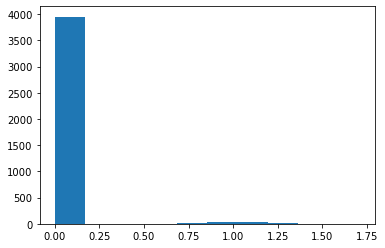

In [34]:
length = []
for i in range(len(embedding_weight)):
    length.append(np.mean(np.square(embedding_weight[i])))


import matplotlib.pyplot as plt
plt.hist(length)

In [ ]:
#用相对距离来衡量的话，发现　char1, char2, char3, 对应都是char2, 说明char2太特殊了，　也就是向量太sparse了，embed sz = 300
改成64试试看呢